# Fine-tuning for Semantic Segmentation with 🤗 Transformers
- Ref: 
    - https://github.com/huggingface/notebooks/blob/main/examples/semantic_segmentation.ipynb
    - https://huggingface.co/blog/fine-tune-segformer 
    - https://huggingface.co/docs/transformers/model_doc/segformer#transformers.SegformerForSemanticSegmentation


----

### Conda env : [cv_playgrounds](../../../README.md#setup-a-conda-environment)




## Configure device

In [1]:
#@title
import torch

if torch.backends.mps.is_available():
    t_device = torch.device("mps")
    s_device = "mps"
    print(f"Current memory allocated on MPS: {torch.mps.current_allocated_memory()} bytes")
    print(f"Driver memory allocated on MPS: {torch.mps.driver_allocated_memory()} bytes")
    if torch.mps.driver_allocated_memory() - torch.mps.current_allocated_memory()< 1e4:
        print("Not enough mps memory, convert to cpu mode")
        t_device = torch.device("cpu")
        s_device = "cpu"
elif torch.cuda.is_available():
    t_device = torch.device("cuda")
    s_device = "cuda"
else:
    t_device = torch.device("cpu")
    s_device = "cpu"
print(t_device)

cuda


## Fine-tuning a model on a semantic segmentation task

### Dataset

In [2]:
from datasets import load_dataset

hf_dataset_identifier = "segments/sidewalk-semantic"
ds = load_dataset(hf_dataset_identifier)

/tmp/ipykernel_164811/1230539601.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


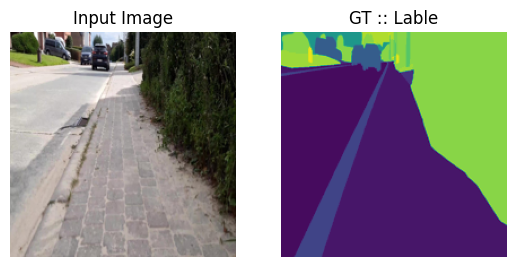

In [3]:
import matplotlib.pyplot as plt

example = ds["train"][10]
test_img = example["pixel_values"].resize((200, 200))
test_label = example["label"].resize((200, 200))

fig, axis = plt.subplots(1, 2)
axis[0].imshow(test_img)
axis[0].set_axis_off()
axis[0].set_title("Input Image")
axis[1].imshow(test_label)
axis[1].set_axis_off()
axis[1].set_title("GT :: Lable")

fig.show()

In [4]:
from huggingface_hub import hf_hub_download
import json

filename = "id2label.json"
id2label = json.load(
    open(hf_hub_download(hf_dataset_identifier, filename, repo_type="dataset"), "r")
)
id2label = {int(k): v for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}

num_labels = len(id2label)

num_labels, list(label2id.keys())

(35,
 ['unlabeled',
  'flat-road',
  'flat-sidewalk',
  'flat-crosswalk',
  'flat-cyclinglane',
  'flat-parkingdriveway',
  'flat-railtrack',
  'flat-curb',
  'human-person',
  'human-rider',
  'vehicle-car',
  'vehicle-truck',
  'vehicle-bus',
  'vehicle-tramtrain',
  'vehicle-motorcycle',
  'vehicle-bicycle',
  'vehicle-caravan',
  'vehicle-cartrailer',
  'construction-building',
  'construction-door',
  'construction-wall',
  'construction-fenceguardrail',
  'construction-bridge',
  'construction-tunnel',
  'construction-stairs',
  'object-pole',
  'object-trafficsign',
  'object-trafficlight',
  'nature-vegetation',
  'nature-terrain',
  'sky',
  'void-ground',
  'void-dynamic',
  'void-static',
  'void-unclear'])

### Model

In [5]:
model_checkpoint = "nvidia/mit-b0"  # pre-trained model from which to fine-tune
batch_size = 4  # batch size for training and evaluation

In [6]:
from transformers import AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained(model_checkpoint)
feature_extractor

/home/hyunjae/anaconda3/envs/dl_drill_pthf/lib/python3.10/site-packages/transformers/models/segformer/feature_extraction_segformer.py:30: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
/home/hyunjae/anaconda3/envs/dl_drill_pthf/lib/python3.10/site-packages/transformers/utils/deprecation.py:172: UserWarning: The following named arguments are not valid for `SegformerFeatureExtractor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


SegformerFeatureExtractor {
  "do_normalize": true,
  "do_reduce_labels": false,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "SegformerFeatureExtractor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 512,
    "width": 512
  }
}

In [7]:
from transformers import SegformerForSemanticSegmentation


model = SegformerForSemanticSegmentation.from_pretrained(
    model_checkpoint,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,  # Will ensure the segmentation specific components are reinitialized.
).to(t_device)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Inference

In [8]:
#@title `def sidewalk_palette()`

def sidewalk_palette():
    """Sidewalk palette that maps each class to RGB values."""
    return [
        [0, 0, 0],
        [216, 82, 24],
        [255, 255, 0],
        [125, 46, 141],
        [118, 171, 47],
        [161, 19, 46],
        [255, 0, 0],
        [0, 128, 128],
        [190, 190, 0],
        [0, 255, 0],
        [0, 0, 255],
        [170, 0, 255],
        [84, 84, 0],
        [84, 170, 0],
        [84, 255, 0],
        [170, 84, 0],
        [170, 170, 0],
        [170, 255, 0],
        [255, 84, 0],
        [255, 170, 0],
        [255, 255, 0],
        [33, 138, 200],
        [0, 170, 127],
        [0, 255, 127],
        [84, 0, 127],
        [84, 84, 127],
        [84, 170, 127],
        [84, 255, 127],
        [170, 0, 127],
        [170, 84, 127],
        [170, 170, 127],
        [170, 255, 127],
        [255, 0, 127],
        [255, 84, 127],
        [255, 170, 127],
    ]

In [9]:
import numpy as np

def get_seg_overlay(image, seg):
  color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3
  palette = np.array(sidewalk_palette())
  for label, color in enumerate(palette):
      color_seg[seg == label, :] = color

  # Show image + mask
  img = np.array(image) * 0.5 + color_seg * 0.5
  img = img.astype(np.uint8)

  return img

In [10]:
from torch import nn

inputs = feature_extractor(images=test_img, return_tensors="pt").to(t_device)
outputs = model(**inputs)
logits = outputs.logits.cpu()  # shape (batch_size, num_labels, height/4, width/4)

# First, rescale logits to original image size
upsampled_logits = nn.functional.interpolate(
    logits,
    size=test_img.size[::-1], # (height, width)
    mode='bilinear',
    align_corners=False
)

# Second, apply argmax on the class dimension
pre_pred_seg = upsampled_logits.argmax(dim=1)[0]

/tmp/ipykernel_164811/2886486355.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()


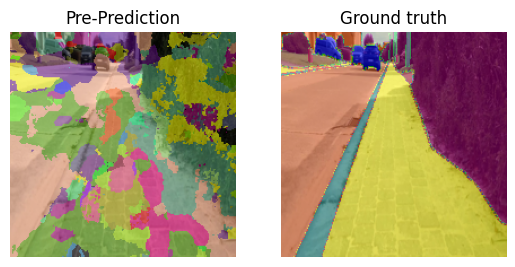

In [11]:
import matplotlib.pyplot as plt

pre_pred_img = get_seg_overlay(test_img, pre_pred_seg.cpu())
gt_img = get_seg_overlay(test_img, np.array(test_label))

f, axis = plt.subplots(1, 2)

axis[0].set_title("Pre-Prediction")
axis[0].imshow(pre_pred_img)
axis[0].set_axis_off()
axis[1].set_title("Ground truth")
axis[1].imshow(gt_img)
axis[1].set_axis_off()

f.show()

### Fine-tuning

In [12]:
ds = ds.shuffle(seed=1)
ds = ds["train"].train_test_split(test_size=0.2)
train_ds = ds["train"]
test_ds = ds["test"]

In [ ]:
from torchvision.transforms import ColorJitter
# from transformers import SegformerFeatureExtractor

# feature_extractor = SegformerFeatureExtractor()
jitter = ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.1)

def train_transforms(example_batch):
    images = [jitter(x) for x in example_batch['pixel_values']]
    labels = [x for x in example_batch['label']]
    inputs = feature_extractor(images, labels)
    return inputs


def val_transforms(example_batch):
    images = [x for x in example_batch['pixel_values']]
    labels = [x for x in example_batch['label']]
    inputs = feature_extractor(images, labels)
    return inputs


# Set transforms
train_ds.set_transform(train_transforms)
test_ds.set_transform(val_transforms)

In [14]:
from transformers import TrainingArguments

epochs = 50
lr = 0.00006
batch_size = 2

hub_model_id = "segformer-b0-finetuned-segments-sidewalk-2"

training_args = TrainingArguments(
    "./temp/segformer-b0-finetuned-segments-sidewalk-outputs",
    learning_rate=lr,
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    save_total_limit=3,
    eval_strategy="steps",
    save_strategy="steps",
    save_steps=200,
    eval_steps=200,
    logging_steps=1,
    eval_accumulation_steps=5,
    load_best_model_at_end=True,
    # push_to_hub=True,
    # hub_model_id=hub_model_id,
    # hub_strategy="end",
)

In [ ]:
import torch
from torch import nn
import evaluate

metric = evaluate.load("mean_iou")

def compute_metrics(eval_pred):
  with torch.no_grad():
    logits, labels = eval_pred
    logits_tensor = torch.from_numpy(logits)
    # scale the logits to the size of the label
    logits_tensor = nn.functional.interpolate(
        logits_tensor,
        size=labels.shape[-2:],
        mode="bilinear",
        align_corners=False,
    ).argmax(dim=1)

    pred_labels = logits_tensor.detach().cpu().numpy()
    # currently using _compute instead of compute
    # see this issue for more info: https://github.com/huggingface/evaluate/pull/328#issuecomment-1286866576
    metrics = metric._compute(
            predictions=pred_labels,
            references=labels,
            num_labels=len(id2label),
            ignore_index=0,
            reduce_labels=feature_extractor.do_reduce_labels,
        )

    # add per category metrics as individual key-value pairs
    per_category_accuracy = metrics.pop("per_category_accuracy").tolist()
    per_category_iou = metrics.pop("per_category_iou").tolist()

    metrics.update({f"accuracy_{id2label[i]}": v for i, v in enumerate(per_category_accuracy)})
    metrics.update({f"iou_{id2label[i]}": v for i, v in enumerate(per_category_iou)})

    return metrics

In [16]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    tokenizer=feature_extractor,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)

[2025-07-25 15:57:15,072] [INFO] [real_accelerator.py:254:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/tmp/ipykernel_164811/1859173989.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/home/hyunjae/anaconda3/envs/dl_drill_pthf/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/home/hyunjae/anaconda3/envs/dl_drill_pthf/compiler_compat/ld: warning: librt.so.1, needed by /usr/local/cuda/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/home/hyunjae/anaconda3/envs/dl_drill_pthf/compiler_compat/ld: warning: libpthread.so.0, needed by /usr/local/cuda/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/home/hyunjae/anaconda3/envs/dl_drill_pthf/compiler_compat/ld: warning: libstdc++.so.6, needed by /usr/local/cuda/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/home/hyunjae/anaconda3/envs/dl_drill_pthf/compiler_compat/ld: warning: libm.so.6, needed by /usr/local/cuda/lib64/libcufile

[2025-07-25 15:57:17,055] [INFO] [logging.py:107:log_dist] [Rank -1] [TorchCheckpointEngine] Initialized with serialization = False


In [17]:
trainer.train()

Step,Training Loss,Validation Loss,Mean Iou,Mean Accuracy,Overall Accuracy,Accuracy Unlabeled,Accuracy Flat-road,Accuracy Flat-sidewalk,Accuracy Flat-crosswalk,Accuracy Flat-cyclinglane,Accuracy Flat-parkingdriveway,Accuracy Flat-railtrack,Accuracy Flat-curb,Accuracy Human-person,Accuracy Human-rider,Accuracy Vehicle-car,Accuracy Vehicle-truck,Accuracy Vehicle-bus,Accuracy Vehicle-tramtrain,Accuracy Vehicle-motorcycle,Accuracy Vehicle-bicycle,Accuracy Vehicle-caravan,Accuracy Vehicle-cartrailer,Accuracy Construction-building,Accuracy Construction-door,Accuracy Construction-wall,Accuracy Construction-fenceguardrail,Accuracy Construction-bridge,Accuracy Construction-tunnel,Accuracy Construction-stairs,Accuracy Object-pole,Accuracy Object-trafficsign,Accuracy Object-trafficlight,Accuracy Nature-vegetation,Accuracy Nature-terrain,Accuracy Sky,Accuracy Void-ground,Accuracy Void-dynamic,Accuracy Void-static,Accuracy Void-unclear,Iou Unlabeled,Iou Flat-road,Iou Flat-sidewalk,Iou Flat-crosswalk,Iou Flat-cyclinglane,Iou Flat-parkingdriveway,Iou Flat-railtrack,Iou Flat-curb,Iou Human-person,Iou Human-rider,Iou Vehicle-car,Iou Vehicle-truck,Iou Vehicle-bus,Iou Vehicle-tramtrain,Iou Vehicle-motorcycle,Iou Vehicle-bicycle,Iou Vehicle-caravan,Iou Vehicle-cartrailer,Iou Construction-building,Iou Construction-door,Iou Construction-wall,Iou Construction-fenceguardrail,Iou Construction-bridge,Iou Construction-tunnel,Iou Construction-stairs,Iou Object-pole,Iou Object-trafficsign,Iou Object-trafficlight,Iou Nature-vegetation,Iou Nature-terrain,Iou Sky,Iou Void-ground,Iou Void-dynamic,Iou Void-static,Iou Void-unclear
200,1.783500,1.371377,0.139813,0.185055,0.715200,nan,0.724896,0.935833,0.000000,0.004160,0.000112,nan,0.000004,0.000000,0.000000,0.845459,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.922396,0.000000,0.000000,0.000000,0.000000,nan,0.000000,0.000000,0.000000,0.000000,0.893496,0.754049,0.841341,0.000000,0.000000,0.000000,0.000000,nan,0.453520,0.760961,0.000000,0.004160,0.000112,nan,0.000004,0.000000,0.000000,0.562877,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.464579,0.000000,0.000000,0.000000,0.000000,nan,0.000000,0.000000,0.000000,0.000000,0.748214,0.680731,0.798872,0.000000,0.000000,0.000000,0.000000
400,1.009300,1.051580,0.160449,0.205906,0.747686,nan,0.875959,0.912089,0.000000,0.492484,0.040386,nan,0.002970,0.000000,0.000000,0.860099,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.888840,0.000000,0.000000,0.000000,0.000000,nan,0.000000,0.000014,0.000000,0.000000,0.953600,0.643325,0.919235,0.000000,0.000000,0.000000,0.000000,nan,0.523440,0.793027,0.000000,0.466772,0.039731,nan,0.002965,0.000000,0.000000,0.634999,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.531780,0.000000,0.000000,0.000000,0.000000,nan,0.000000,0.000014,0.000000,0.000000,0.713294,0.599232,0.829100,0.000000,0.000000,0.000000,0.000000
600,1.536300,0.894012,0.176132,0.226123,0.762369,nan,0.909206,0.893744,0.000000,0.559497,0.124159,nan,0.132261,0.000000,0.000000,0.910982,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.896777,0.000000,0.061060,0.000000,0.000000,nan,0.000000,0.000024,0.000000,0.000000,0.892519,0.915025,0.940695,0.000000,0.000000,0.000000,0.000000,nan,0.522563,0.795332,0.000000,0.477874,0.114430,nan,0.115510,0.000000,0.000000,0.625055,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.580318,0.000000,0.060412,0.000000,0.000000,nan,0.000000,0.000024,0.000000,0.000000,0.784939,0.698316,0.861448,0.000000,0.000000,0.000000,0.000000
800,0.982900,0.800270,0.195723,0.246005,0.785455,nan,0.694739,0.942659,0.000000,0.710277,0.375327,nan,0.267713,0.000000,0.000000,0.936949,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.917191,0.000000,0.266597,0.000000,0.000000,nan,0.000000,0.003008,0.000000,0.000000,0.927220,0.896124,0.934347,0.000000,0.000000,0.000003,0.000000,nan,0.582970,0.815473,0.000000,0.473257,0.287334,nan,0.210266,0.000000,0.000000,

/home/hyunjae/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/home/hyunjae/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
/home/hyunjae/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/home/hyunjae/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:260: Runt

TrainOutput(global_step=20000, training_loss=0.3024135661251843, metrics={'train_runtime': 9270.6084, 'train_samples_per_second': 4.315, 'train_steps_per_second': 2.157, 'total_flos': 7.0271895601152e+17, 'train_loss': 0.3024135661251843, 'epoch': 50.0})

### Validation

In [18]:
post_outputs = model(**inputs)
post_logits = post_outputs.logits.cpu()  # shape (batch_size, num_labels, height/4, width/4)

# First, rescale logits to original image size
post_upsampled_logits = nn.functional.interpolate(
    post_logits,
    size=test_img.size[::-1], # (height, width)
    mode='bilinear',
    align_corners=False
)

# Second, apply argmax on the class dimension
post_pred_seg = post_upsampled_logits.argmax(dim=1)[0]

/tmp/ipykernel_164811/2566276033.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()


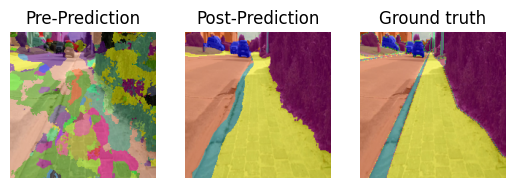

In [19]:
import matplotlib.pyplot as plt

post_pred_img = get_seg_overlay(test_img, post_pred_seg.cpu())


f, axis = plt.subplots(1, 3)

axis[0].set_title("Pre-Prediction")
axis[0].imshow(pre_pred_img)
axis[0].set_axis_off()
axis[1].set_title("Post-Prediction")
axis[1].imshow(post_pred_img)
axis[1].set_axis_off()
axis[2].set_title("Ground truth")
axis[2].imshow(gt_img)
axis[2].set_axis_off()

f.show()

In [20]:
print("Done")

Done
